<a href="https://colab.research.google.com/github/huxiaodao/AI-/blob/main/Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wrapper for SwinIR

> Demo notebook for [__Wrapper for SwinIR__](https://github.com/Lin-Sinorodin/SwinIR_wrapper) repository. This wrapper based on the official PyTorch implementation of [SwinIR: Image Restoration Using Shifted Window Transformer](https://arxiv.org/abs/2108.10257). Check the repo for more details.





In [1]:
#@title Imports and Utils { display-mode: "form" }

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
%config InlineBackend.rc = {'figure.figsize': (10.0, 10.0)}

!git clone -qq https://github.com/Lin-Sinorodin/SwinIR_wrapper.git
!pip install -qq timm
from SwinIR_wrapper.SwinIR_wrapper import SwinIR_SR

import cv2
import torch
import urllib.request
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    print(f'Using GPU: {torch.cuda.get_device_properties(0).name}')
else:
    print('Using CPU. Concider using GPU for faster inference.')

def compare_sr_with_original(img_lq, img_hq):
    plt.figure()

    plt.subplot(1, 2, 1)
    plt.imshow(img_lq[::,::,::-1])
    plt.title(f'Original - {img_lq.shape}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img_hq[::,::,::-1])
    plt.title(f'Super Resolution - {img_hq.shape}')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 51.2 MB/s eta 0:00:00


/content/SwinIR_wrapper/SwinIR_wrapper/SwinIR.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Using CPU. Concider using GPU for faster inference.


/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)




---



In [2]:
#@title Get Test Image { run: "auto", display-mode: "form" }

#@markdown > #### Choose between uploading image or downloading from url:
get_image_method = "download from url" #@param ["upload file", "download from url"]

#@markdown * for uploaded image, write it's path:
uploaded_file = "/content/my_uploaded_image.jpeg" #@param {type:"string"}
if get_image_method == 'upload file':
    path = uploaded_file

#@markdown * for url download, provide the image url:
url = 'https://map.pepperdine.edu/maps/UMAP_2011012422072_6_8_19.jpg' #@param {type:"string"}
if get_image_method == 'download from url':
    path = url.split('/')[-1]
    urllib.request.urlretrieve(url, path)



---



In [3]:
#@title Setup Super Resolution Model { run: "auto" }
pretrained_model = "lightweight x2" #@param ["real_sr x4", "classical_sr x2", "classical_sr x3", "classical_sr x4", "classical_sr x8", "lightweight x2", "lightweight x3", "lightweight x4"]

model_type, scale = pretrained_model.split(' ')
scale = int(scale[1])

# initialize super resolution model
sr = SwinIR_SR(model_type, scale)

print(f'Loaded {pretrained_model} successfully')

downloading weights to /content/SwinIR_wrapper/SwinIR_wrapper/weights/002_lightweightSR_DIV2K_s64w8_SwinIR-S_x2.pth
Loaded lightweight x2 successfully


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]




---



## Use The Model

> If the image size isn't too big, the image can be fed to the model as it is However, for larger images the GPU will run out of memory. A simple solution is to use the model on smaller patches and then combine the results for a large image.

### Directly - `sr.upscale()`


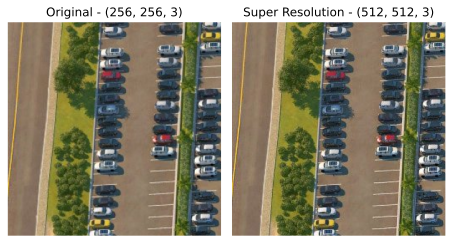

In [4]:
# load the test image from previus step
img_lq = cv2.imread(path, cv2.IMREAD_COLOR)

# feed the image to the SR model
img_hq = sr.upscale(img_lq)

# show results
compare_sr_with_original(img_lq, img_hq)

### On Patches - `sr.upscale_using_patches()`

In [ ]:
# load the test image from previus step
img_lq = cv2.imread(path, cv2.IMREAD_COLOR)

# feed the image to the SR model
img_hq = sr.upscale_using_patches(img_lq, slice_dim=64, keep_pbar=True)

# show results
compare_sr_with_original(img_lq, img_hq)

Performing SR on patches:   0%|          | 0/16 [00:00<?, ?patch/s]